# 变换三维对象


In [23]:
try:
    import sys
    # 将项目根路径加入系统路径集合, 即可以引入相关的包
    sys.path.append("../..")
finally:
    pass

# 引入所需的包
from vectors import rotate2d, to_polar, to_cartesian, Triangle, scale
from common.vectors_draw import (
    draw2d, draw3d, Color, Vector2D, Vector3D,
    Points2D, Arrow2D,
    Points3D, Arrow3D, Polygon3D,
)
from math import pi
from typing import Sequence, Generator


一般情况下, 变换即以一个向量为输入, 计算后的向量为输出, 类似如下代码

```python
def transform(v: Vector) -> Vector:
    x, y, z = v
    # 进行计算
    return (new_x, new_y, new_z)
```


## 1. 绘制变换后的对象


### 1.1. 绘制原始模型


**练习:** 读取模型文件

模型文件由三部分组成: 
- 整体信息: 包括第一行的 `OFF` 标记和第二行的 `480  448  926`, 表示每部分数据的行数
- 向量信息: 除头两行外, 前 `480` 行数据表示三维向量
- 多面体信息: 除头两行外, 从 `480` 行到 `480 + 448 = 928` 行为平面定义数据, 每组为 `5` 个数字, 后 `4` 个表示前 `480` 行向量的行号, `4` 个向量组成两个三角形

尝试读取 `4 439 438 8 9` 对应的数据

In [24]:
def triangulate(poly: Sequence[Vector3D]) -> Generator[Triangle, None, None]:
    """
    将传入的四个三维向量组合成两个三角形

    Args:
        poly (Sequence[Vector3D]): 一组由四个三维向量组成的集合

    Yields:
        Generator[Triangle, None, None]: 返回一个生成器, 产生相关的两个三角形向量集合 
    """
    # 确认每个多面体都有三个向量组成
    if len(poly) < 3:
        raise ValueError("polygons must have at least 3 vertices")

    # 将四个向量坐标拆分成两个三角形
    for i in range(1, len(poly) - 1):
        yield (poly[0], poly[i + 1], poly[i])


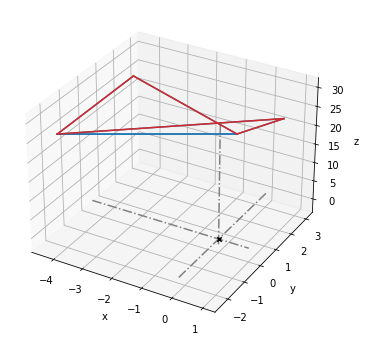

In [45]:
# 读取的 4 439 438 8 9 这行数据对应的四个向量
vs = [
    (-0.0827332, -0.0421881, 0.529498),
    (-0.0827332, 0.0421881,  0.529498),
    (0.0107422, 0, 0.575333),
    (0.0125, 0.0562508, 0.450561),
]

# 向量放大 50 倍
vs = [scale(v, 50.0) for v in vs]

# 将四个三维向量计算为两个三角形面
polygons = [Polygon3D(*t, color=Color.blue) for t in triangulate(vs)]

# 绘制
draw3d(
    *polygons,  # 绘制四个向量拆分的两个三角形
    Polygon3D(*vs, color=Color.red),  # 绘制四个向量组成的图形
)


**练习:** 绘制原始模型


In [43]:
!python draw_teapot.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### 1.2. 将原始模型放大 2 倍


**知识:** 通过 [`scale` 函数](./vectors.py), 通过放大向量长度, 进一步可以将向量组成的三角形放大

整个操作相当于将输入向量置于多个"处理器", 每个处理器的输出是下一个处理器的输入

![X](../assets/transform1.jpg)

将这些处理器连接起来后, 即可对输入向量进行各种处理

![X](../assets/transform2.jpg)


**练习:** 绘制放大 `2` 倍后的模型


In [27]:
!python scale_teapot.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### 1.3. 绕固定坐标轴旋转向量


**知识:** 旋转二维向量

对于二维向量, 改变其角度的方法为: 将笛卡儿坐标转换为极坐标, 按旋转系数增加或减少角度, 然后再转换回来


In [28]:
def rotate2d(angle: float, v: Vector2D) -> Vector2D:
    """
    将一个二维向量旋转指定弧度

    Args:
        angle (float): 要旋转的弧度
        v (Vector2D): 要旋转的向量

    Returns:
        Vector2D: 旋转角度后的新向量
    """
    # 将向量转为极坐标
    l, a = to_polar(v)
    # 将极坐标的角度分量增加指定弧度后转为笛卡尔坐标向量
    return to_cartesian((l, a + angle))


**练习:** 将二维向量 $(0, 1)$ 逆时针旋转 $90\degree$ 以及顺时针旋转 $45\degree$


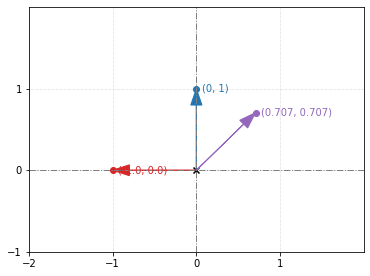

In [29]:
# 定义二维坐标
v = (0, 1)

# 向左旋转 90°
v_new1 = rotate2d(pi / 2, v)
# 向右旋转 45°
v_new2 = rotate2d(-(pi / 4), v)

# 绘制图形
draw2d(
    Points2D(v, color=Color.blue),
    Arrow2D(v, color=Color.blue),
    Points2D(v_new1, color=Color.red),
    Arrow2D(v_new1, color=Color.red),
    Points2D(v_new2, color=Color.purple),
    Arrow2D(v_new2, color=Color.purple),
    grid=(1, 1),
)


**知识:** 旋转三维向量

旋转二维向量的方法在三维空间也适用. 从某种意义上说, 所有的三维向量旋转在平面上都是孤立的. 例如, 试想三维点绕 $z$ 轴旋转, 其 $x$ 坐标和 $y$ 坐标会改变, 但 $z$ 坐标不变. 如果一个给定的点绕 $z$ 轴旋转, 无论旋转角度如何, 其 $z$ 坐标都不会改变, 该点保持在一个圆内

![X](../assets/rotate_by.jpg)


In [30]:
def rotate_z(angle: float, vector: Vector3D) -> Vector3D:
    """
    将三维向量围绕 `z` 轴进行旋转

    Args:
        angle (float): 旋转角度
        vector (Vector3D): 要选择的三维向量

    Returns:
        Vector3D: 旋转角度后的三维向量
    """
    # 获取三维分量
    x, y, z = vector
    # z 轴不变, 旋转 x, y 坐标
    new_x, new_y = rotate2d(angle, (x, y))
    # 返回旋转后的坐标
    return new_x, new_y, z


**练习:** 将三维向量 $(1, 0, 0)$ 围绕 $z$ 坐标轴旋转 $90\degree$ 以及 $-45\degree$


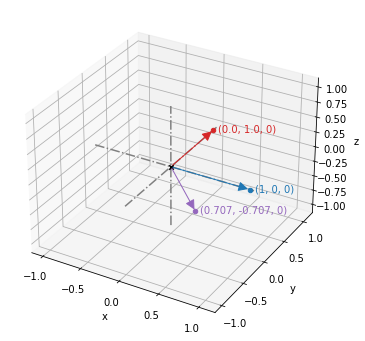

In [31]:
# 定义三维变量
v = (1, 0, 0)

# 围绕 y 轴旋转向量
# 旋转 90°
v_new1 = rotate_z(pi / 2, v)
# 旋转 45°
v_new2 = rotate_z(-(pi / 4), v)

# 绘制图形
draw3d(
    Points3D(v, color=Color.blue),
    Arrow3D(v, color=Color.blue),
    Points3D(v_new1, color=Color.red),
    Arrow3D(v_new1, color=Color.red),
    Points3D(v_new2, color=Color.purple),
    Arrow3D(v_new2, color=Color.purple),
)


**练习:** 绘制旋转 $45\degree$ 后的模型


In [32]:
!python rotate_teapot_z.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [33]:
!python rotate_teapot_x.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### 1.4. 自定义几何变换

**知识:** 可以针对向量的某个轴的分量进行拉伸

In [34]:
def stretch(v: Vector3D, sx: float = 1.0, sy: float = 1.0, sz: float = 1.0) -> Vector3D:
    """
    拉伸一个向量

    Args:
        v (Vector3D): 要拉伸的三维向量
        sx (float, optional): `x` 轴拉伸倍数. Defaults to `1.0`.
        sy (float, optional): `y` 轴拉伸倍数. Defaults to `1.0`.
        sz (float, optional): `z` 轴拉伸倍数. Defaults to `1.0`.

    Returns:
        Vector3D: 拉伸后的向量
    """
    x, y, z = v
    return (x * sx, y * sy, z * sz)


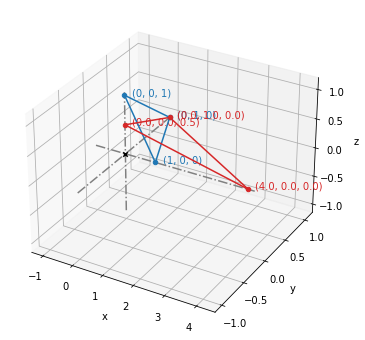

In [35]:
face = (
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1)
)

new_face = [stretch(v, sx=4.0, sz=0.5) for v in face]

draw3d(
    Points3D(*face, color=Color.blue),
    Polygon3D(*face, color=Color.blue),
    Points3D(*new_face, color=Color.red),
    Polygon3D(*new_face, color=Color.red),
)


**练习:** 将模型 x 轴方向拉伸 4 倍

In [36]:
!python stretch_teapot_x.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


**练习:** 将模型 y 轴方向拉伸 4 倍

In [37]:
!python stretch_teapot_y.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


**练习:** 将向量的指定维度拉伸其原始维度的三次方

因为拉伸的长度为指定向量维度的三次方, 所以对于向量长度大于 `1` 的, 相当于"拉伸"; 向量长度小于 `1` 的, 相当于"缩小"

In [46]:
def cube_stretch(v: Vector3D, dim=(1, 1, 1)) -> Vector3D:
    """
    三次方拉伸一个向量, 即拉伸向量指定维度的三次方

    Args:
        v (Vector3D): 要拉伸的三维向量
        dim (tuple, optional): 要拉伸的纬度. Defaults to `(1, 1, 1)`.

    Returns:
        Vector3D: _description_
    """
    return stretch(
        v,
        sx=v[0] ** 2 if dim[0] else 1.0,
        sy=v[1] ** 2 if dim[1] else 1.0,
        sz=v[2] ** 2 if dim[2] else 1.0,
    )


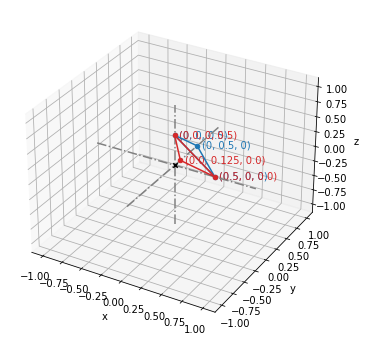

In [50]:
face = (
    (0.5, 0, 0),
    (0, 0.5, 0),
    (0, 0, 0.5)
)

new_face = [cube_stretch(v, dim=(0, 1, 0)) for v in face]

draw3d(
    Points3D(*face, color=Color.blue),
    Polygon3D(*face, color=Color.blue),
    Points3D(*new_face, color=Color.red),
    Polygon3D(*new_face, color=Color.red),
)


**练习:** 将茶壶的垂直尺寸按三次方拉伸

In [51]:
!python cube_teapot.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


**练习:** 为现有的 $x$ 坐标加上 $y$ 坐标, 使茶壶向 $z$ 方向倾斜

In [52]:
!python cube_teapot.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


**练习:** 令茶壶沿 $x$ 轴向下平移 `20` 个单位

将茶壶各个向量的 `z` 轴分量向负方向移动 `20` 个单位 (`add(v, (0, 0, -20))`), 呈现茶壶远离的效果

In [53]:
!python translate_teapot_down_z.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


**练习:** 当按 `0` 和 `1` 之间的标量缩放每一个向量时, 茶壶会发生什么变化? 按系数 `-1` 缩放, 又会发生什么变化?

In [54]:
# 向量乘以 0.5, 相当于缩小 1/2
!python scale_teapot_0.5.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [56]:
# 向量乘以 -1, 相当于 x, y, z 轴全部翻转
!python scale_teapot_-1.py


pygame 2.1.2 (SDL 2.0.18, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


**知识:** 向量的镜像操作. 注意: 对于一个多面体来说, 这种镜像不仅是"上下左右"进行了翻转, "里外"也进行了翻转

给向量乘以标量 `-1`, 即可将向量的三个坐标轴移动到相反的位置.

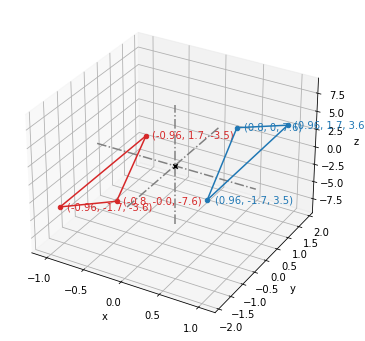

In [59]:
# 定义一组向量, 表示一个三角形
face = [
    (0.8, 0, 7.6),
    (0.96, 1.7, 3.6),
    (0.96, -1.7, 3.5),
]

# 计算 face 向量集合的镜像向量集合
face_new = [scale(f, -1.0) for f in face]

# 绘制互为镜像的两个三角形
draw3d(
    Points3D(*face, color=Color.blue),
    Polygon3D(*face, color=Color.blue),
    Points3D(*face_new, color=Color.red),
    Polygon3D(*face_new, color=Color.red),
)
